In [1]:
from utils import read_data
from utils import result

import xgboost as xgb

import tensorflow as tf

import os
import pandas as pd
import re
import string
import numpy as np
import json

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from gensim.models import doc2vec
import gensim
import random
from tqdm import tqdm
import xgboost as xgb

np.random.seed(202301)

import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [41]:
plt.style.use('ggplot')

In [2]:
train_sentence, test_sentence, sarcasm_sentence, train_token, test_token, sarcasm_token, y_train, y_test, y_sarcasm = read_data()

In [3]:
def twitter_vec(tweet, model, size=300):
    '''
    :param tweet: context of tweet
    :return: vec, vector representation of this tweet
    '''
    context = np.zeros(size)
    count = 0
    for word in tweet:
        try:
            context += model.wv[word]
            count += 1
        except:
            continue
    if count > 0:
        context = context / count
    return context

impact of epoch

In [4]:
%%time
xgb_epoch = [[], [], [], [], [], []]
ann_epoch = [[], [], [], [], [], []]
svc_epoch = [[], [], [], [], [], []]

vocab = train_token + test_token + sarcasm_token

for epoch in tqdm([5, 10, 100, 200, 1000]):

    word2vec = Word2Vec(sentences=vocab, epochs=epoch, vector_size=300, window=5, min_count=1, workers=9)


    train_vector = [twitter_vec(tweet, word2vec) for tweet in train_token]
    train_vector = np.array(train_vector)

    test_vector = [twitter_vec(tweet, word2vec) for tweet in test_token]
    test_vector = np.array(test_vector)

    sarcasm_vector = [twitter_vec(tweet, word2vec) for tweet in sarcasm_token]
    sarcasm_vector = np.array(sarcasm_vector)

    model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(300, )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)
])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(train_vector, y_train, epochs=20, verbose=0)
    pred = np.array(tf.argmax(model.predict(test_vector, verbose=0), axis=1))
    pred_sarcasm = np.array(tf.argmax(model.predict(sarcasm_vector, verbose=0), axis=1))
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    ann_epoch[0].append(r1)
    ann_epoch[1].append(r2)
    ann_epoch[2].append(r3)
    ann_epoch[3].append(r4)
    ann_epoch[4].append(r5)
    ann_epoch[5].append(r6)


    model = xgb.XGBClassifier()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    xgb_epoch[0].append(r1)
    xgb_epoch[1].append(r2)
    xgb_epoch[2].append(r3)
    xgb_epoch[3].append(r4)
    xgb_epoch[4].append(r5)
    xgb_epoch[5].append(r6)

    model = SVC()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    svc_epoch[0].append(r1)
    svc_epoch[1].append(r2)
    svc_epoch[2].append(r3)
    svc_epoch[3].append(r4)
    svc_epoch[4].append(r5)
    svc_epoch[5].append(r6)

  0%|          | 0/5 [00:00<?, ?it/s]

Metal device set to: Apple M1 Pro


2023-01-07 00:54:48.531098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-07 00:54:48.531277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-07 00:54:48.756655: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-07 00:54:48.940813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 00:58:21.677473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[00:58:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 20%|██        | 1/5 [18:01<1:12:05, 1081.43s/it]2023-01-07 01:12:52.939046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 01:16:03.646750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[01:16:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 40%|████      | 2/5 [33:50<50:10, 1003.50s/it]  2023-01-07 01:29:01.765415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 01:32:23.946458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[01:32:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 60%|██████    | 3/5 [54:50<37:21, 1120.59s/it]2023-01-07 01:50:36.532939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 01:54:05.440506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[01:54:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 80%|████████  | 4/5 [1:17:37<20:17, 1217.91s/it]2023-01-07 02:16:40.753847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 02:19:40.795903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[02:19:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 5/5 [1:42:49<00:00, 1233.98s/it]

CPU times: user 2h 44min 13s, sys: 9min 26s, total: 2h 53min 39s
Wall time: 1h 42min 49s


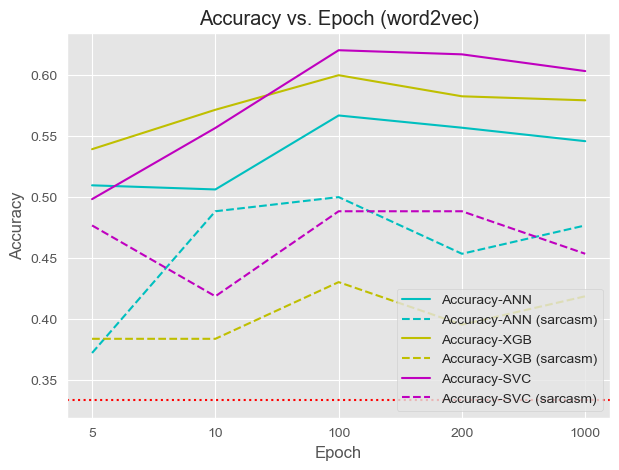

In [58]:
xgb_epoch = np.array(xgb_epoch)
ann_epoch = np.array(ann_epoch)
svc_epoch = np.array(svc_epoch)

plt.rcParams["figure.figsize"] = (7, 5)
epoch = ['5', '10', '100', '200', '1000']

x = np.arange(5)
plt.plot(x, ann_epoch[0], 'c', label='Accuracy-ANN ')
plt.plot(x, ann_epoch[3], 'c--', label='Accuracy-ANN (sarcasm)')

plt.plot(x, xgb_epoch[0], 'y', label='Accuracy-XGB')
plt.plot(x, xgb_epoch[3], 'y--', label='Accuracy-XGB (sarcasm)')

plt.plot(x, svc_epoch[0], 'm', label='Accuracy-SVC')
plt.plot(x, svc_epoch[3], 'm--', label='Accuracy-SVC (sarcasm)')

plt.xticks(np.arange(5), epoch)
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.axhline(y=1/3, color='r', linestyle='dotted')
plt.title("Accuracy vs. Epoch (word2vec)")
plt.savefig('accuracy_word2vec_epoch.png', dpi=1000)
plt.show()

In [65]:
svc_epoch

array([[0.49830846, 0.55671642, 0.62049751, 0.61711443, 0.60338308],
       [0.5322146 , 0.57568149, 0.59893054, 0.60910827, 0.59924011],
       [0.48759113, 0.53073433, 0.57081478, 0.5793277 , 0.56806391],
       [0.47674419, 0.41860465, 0.48837209, 0.48837209, 0.45348837],
       [0.49463869, 0.43919969, 0.4962704 , 0.4789627 , 0.43488733],
       [0.48186946, 0.43215405, 0.51858486, 0.53202729, 0.49826163]])

In [5]:
%%time
xgb_size = [[], [], [], [], [], []]
ann_size = [[], [], [], [], [], []]
svc_size = [[], [], [], [], [], []]

vocab = train_token + test_token + sarcasm_token

for size in tqdm([50, 100, 200, 300, 500, 1000]):

    word2vec = Word2Vec(sentences=vocab, epochs=100, vector_size=size, window=5, min_count=1, workers=9)


    train_vector = [twitter_vec(tweet, word2vec, size=size) for tweet in train_token]
    train_vector = np.array(train_vector)

    test_vector = [twitter_vec(tweet, word2vec, size=size) for tweet in test_token]
    test_vector = np.array(test_vector)

    sarcasm_vector = [twitter_vec(tweet, word2vec, size=size) for tweet in sarcasm_token]
    sarcasm_vector = np.array(sarcasm_vector)

    model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(size, )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)
])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(train_vector, y_train, epochs=20, verbose=0)
    pred = np.array(tf.argmax(model.predict(test_vector, verbose=0), axis=1))
    pred_sarcasm = np.array(tf.argmax(model.predict(sarcasm_vector, verbose=0), axis=1))
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    ann_size[0].append(r1)
    ann_size[1].append(r2)
    ann_size[2].append(r3)
    ann_size[3].append(r4)
    ann_size[4].append(r5)
    ann_size[5].append(r6)

    model = xgb.XGBClassifier()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    xgb_size[0].append(r1)
    xgb_size[1].append(r2)
    xgb_size[2].append(r3)
    xgb_size[3].append(r4)
    xgb_size[4].append(r5)
    xgb_size[5].append(r6)

    model = SVC()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    svc_size[0].append(r1)
    svc_size[1].append(r2)
    svc_size[2].append(r3)
    svc_size[3].append(r4)
    svc_size[4].append(r5)
    svc_size[5].append(r6)

  0%|          | 0/6 [00:00<?, ?it/s]2023-01-07 02:37:57.090588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 02:40:48.202643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[02:40:49] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 17%|█▋        | 1/6 [06:51<34:18, 411.78s/it]2023-01-07 02:44:50.501494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 02:47:41.492927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[02:47:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 33%|███▎      | 2/6 [17:33<36:27, 546.86s/it]2023-01-07 02:55:31.476568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 02:58:29.848441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[02:58:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 50%|█████     | 3/6 [34:11<37:39, 753.11s/it]2023-01-07 03:12:12.956023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 03:15:16.483936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[03:15:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 67%|██████▋   | 4/6 [55:35<32:05, 962.50s/it]2023-01-07 03:33:44.861290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 03:36:46.698732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[03:36:48] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 83%|████████▎ | 5/6 [1:25:02<20:52, 1252.62s/it]2023-01-07 04:03:34.215375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 04:06:30.758379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[04:06:34] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 6/6 [2:13:45<00:00, 1337.55s/it]

CPU times: user 3h 20min 21s, sys: 11min 24s, total: 3h 31min 46s
Wall time: 2h 13min 45s


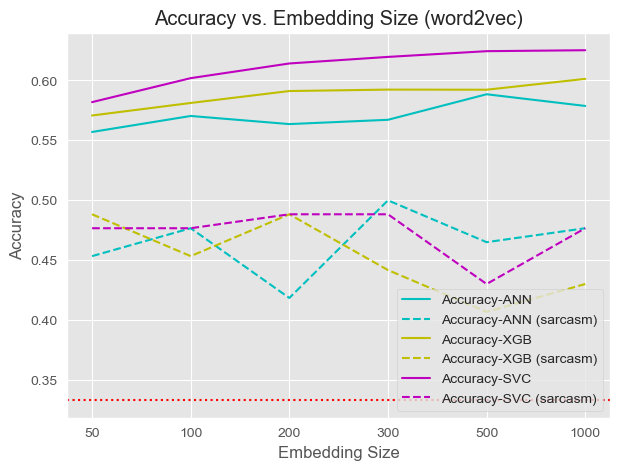

In [57]:
xgb_size = np.array(xgb_size)
ann_size = np.array(ann_size)
svc_size = np.array(svc_size)


plt.rcParams["figure.figsize"] = (7, 5)
size = [50, 100, 200, 300, 500, 1000]

x = np.arange(6)
plt.plot(x, ann_size[0], 'c', label='Accuracy-ANN ')
plt.plot(x, ann_size[3], 'c--', label='Accuracy-ANN (sarcasm)')

plt.plot(x, xgb_size[0], 'y', label='Accuracy-XGB')
plt.plot(x, xgb_size[3], 'y--', label='Accuracy-XGB (sarcasm)')

plt.plot(x, svc_size[0], 'm', label='Accuracy-SVC')
plt.plot(x, svc_size[3], 'm--', label='Accuracy-SVC (sarcasm)')

plt.xticks(np.arange(6), size)
plt.legend(loc='lower right')
plt.axhline(y=1/3, color='r', linestyle='dotted')
plt.xlabel("Embedding Size")
plt.ylabel("Accuracy")
plt.savefig('accuracy_word2vec_embedding.png', dpi=1000)
plt.title("Accuracy vs. Embedding Size (word2vec)")
plt.show()

In [64]:
svc_size

array([[0.58189055, 0.60189055, 0.61412935, 0.61960199, 0.62437811,
        0.62517413],
       [0.56759973, 0.58153158, 0.59397828, 0.59937508, 0.60326716,
        0.60449872],
       [0.53905521, 0.55543666, 0.56790051, 0.5741507 , 0.57644888,
        0.57745379],
       [0.47674419, 0.47674419, 0.48837209, 0.48837209, 0.43023256,
        0.47674419],
       [0.52255245, 0.48970474, 0.4962704 , 0.49803807, 0.41822067,
        0.48793706],
       [0.46363636, 0.49431818, 0.50682261, 0.50892857, 0.46252205,
        0.49272487]])

In [6]:
%%time
xgb_window = [[], [], [], [], [], []]
ann_window = [[], [], [], [], [], []]
svc_window = [[], [], [], [], [], []]

vocab = train_token + test_token + sarcasm_token

for window in tqdm([2, 3, 4, 5, 6]):

    word2vec = Word2Vec(sentences=vocab, epochs=100, vector_size=300, window=window, min_count=1, workers=9)


    train_vector = [twitter_vec(tweet, word2vec) for tweet in train_token]
    train_vector = np.array(train_vector)

    test_vector = [twitter_vec(tweet, word2vec) for tweet in test_token]
    test_vector = np.array(test_vector)

    sarcasm_vector = [twitter_vec(tweet, word2vec) for tweet in sarcasm_token]
    sarcasm_vector = np.array(sarcasm_vector)

    model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(300, )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)
])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(train_vector, y_train, epochs=20, verbose=0)
    pred = np.array(tf.argmax(model.predict(test_vector, verbose=0), axis=1))
    pred_sarcasm = np.array(tf.argmax(model.predict(sarcasm_vector, verbose=0), axis=1))
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    ann_window[0].append(r1)
    ann_window[1].append(r2)
    ann_window[2].append(r3)
    ann_window[3].append(r4)
    ann_window[4].append(r5)
    ann_window[5].append(r6)

    model = xgb.XGBClassifier()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    xgb_window[0].append(r1)
    xgb_window[1].append(r2)
    xgb_window[2].append(r3)
    xgb_window[3].append(r4)
    xgb_window[4].append(r5)
    xgb_window[5].append(r6)

    model = SVC()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    svc_window[0].append(r1)
    svc_window[1].append(r2)
    svc_window[2].append(r3)
    svc_window[3].append(r4)
    svc_window[4].append(r5)
    svc_window[5].append(r6)

  0%|          | 0/5 [00:00<?, ?it/s]2023-01-07 04:51:48.604957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 04:54:38.571055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[04:54:40] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 20%|██        | 1/5 [19:18<1:17:15, 1158.95s/it]2023-01-07 05:11:06.869825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 05:13:58.046539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[05:13:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 40%|████      | 2/5 [39:01<58:37, 1172.57s/it]  2023-01-07 05:30:49.563724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 05:34:35.047639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[05:34:36] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 60%|██████    | 3/5 [1:00:40<41:00, 1230.37s/it]2023-01-07 05:52:29.236748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 05:55:20.894755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[05:55:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 80%|████████  | 4/5 [1:21:49<20:45, 1245.56s/it]2023-01-07 06:13:38.383141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 06:16:29.903346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[06:16:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 5/5 [1:42:29<00:00, 1230.00s/it]

CPU times: user 2h 32min 11s, sys: 7min 58s, total: 2h 40min 10s
Wall time: 1h 42min 30s


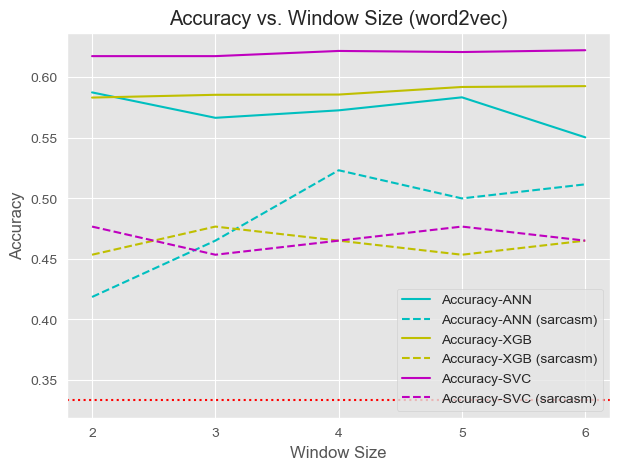

In [59]:
xgb_window = np.array(xgb_window)
ann_window = np.array(ann_window)
svc_window = np.array(svc_window)


plt.rcParams["figure.figsize"] = (7, 5)
window = [2, 3, 4, 5, 6]

x = np.arange(5)
plt.plot(x, ann_window[0], 'c', label='Accuracy-ANN ')
plt.plot(x, ann_window[3], 'c--', label='Accuracy-ANN (sarcasm)')

plt.plot(x, xgb_window[0], 'y', label='Accuracy-XGB')
plt.plot(x, xgb_window[3], 'y--', label='Accuracy-XGB (sarcasm)')

plt.plot(x, svc_window[0], 'm', label='Accuracy-SVC')
plt.plot(x, svc_window[3], 'm--', label='Accuracy-SVC (sarcasm)')

plt.xticks(np.arange(5), window)
plt.legend(loc='lower right')
plt.xlabel("Window Size")
plt.ylabel("Accuracy")
plt.axhline(y=1/3, color='r', linestyle='dotted')
plt.title("Accuracy vs. Window Size (word2vec)")
plt.savefig('accuracy_word2vec_window.png', dpi=1000)
plt.show()

In [63]:
svc_window

array([[0.61751244, 0.61751244, 0.62179104, 0.62089552, 0.62238806],
       [0.60081036, 0.59964219, 0.60277797, 0.59650006, 0.59773703],
       [0.57075904, 0.57162163, 0.57562923, 0.56912505, 0.57095719],
       [0.47674419, 0.45348837, 0.46511628, 0.47674419, 0.46511628],
       [0.50524476, 0.43665501, 0.46229604, 0.45332168, 0.46052836],
       [0.47783587, 0.48571429, 0.49298246, 0.52803129, 0.50176835]])

In [7]:
%%time
xgb_count = [[], [], [], [], [], []]
ann_count = [[], [], [], [], [], []]
svc_count = [[], [], [], [], [], []]

vocab = train_token + test_token + sarcasm_token

for count in tqdm([1, 3, 5, 10, 20]):

    word2vec = Word2Vec(sentences=vocab, epochs=100, vector_size=300, window=5, min_count=count, workers=9)


    train_vector = [twitter_vec(tweet, word2vec) for tweet in train_token]
    train_vector = np.array(train_vector)

    test_vector = [twitter_vec(tweet, word2vec) for tweet in test_token]
    test_vector = np.array(test_vector)

    sarcasm_vector = [twitter_vec(tweet, word2vec) for tweet in sarcasm_token]
    sarcasm_vector = np.array(sarcasm_vector)

    model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(300, )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)
])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(train_vector, y_train, epochs=20, verbose=0)
    pred = np.array(tf.argmax(model.predict(test_vector, verbose=0), axis=1))
    pred_sarcasm = np.array(tf.argmax(model.predict(sarcasm_vector, verbose=0), axis=1))
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    ann_count[0].append(r1)
    ann_count[1].append(r2)
    ann_count[2].append(r3)
    ann_count[3].append(r4)
    ann_count[4].append(r5)
    ann_count[5].append(r6)

    model = xgb.XGBClassifier()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    xgb_count[0].append(r1)
    xgb_count[1].append(r2)
    xgb_count[2].append(r3)
    xgb_count[3].append(r4)
    xgb_count[4].append(r5)
    xgb_count[5].append(r6)

    model = SVC()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    svc_count[0].append(r1)
    svc_count[1].append(r2)
    svc_count[2].append(r3)
    svc_count[3].append(r4)
    svc_count[4].append(r5)
    svc_count[5].append(r6)

  0%|          | 0/5 [00:00<?, ?it/s]2023-01-07 06:34:19.114860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 06:37:09.887832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[06:37:11] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 20%|██        | 1/5 [20:10<1:20:40, 1210.13s/it]2023-01-07 06:54:25.313341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 06:57:14.627717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[06:57:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 40%|████      | 2/5 [40:52<1:01:27, 1229.18s/it]2023-01-07 07:15:07.597665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 07:17:50.829112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[07:17:52] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 60%|██████    | 3/5 [1:01:58<41:32, 1246.01s/it]2023-01-07 07:36:11.527612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 07:38:58.524639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[07:39:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 80%|████████  | 4/5 [1:24:07<21:18, 1278.79s/it]2023-01-07 07:58:17.366911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-07 08:01:48.298458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[08:01:49] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 5/5 [1:47:49<00:00, 1294.00s/it]

CPU times: user 2h 37min 7s, sys: 8min 16s, total: 2h 45min 23s
Wall time: 1h 47min 49s


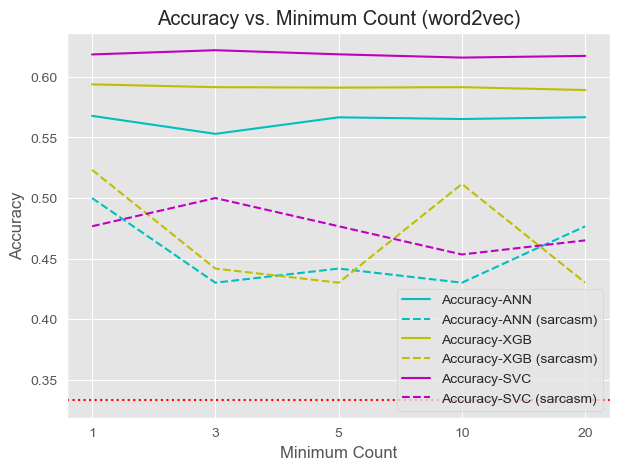

In [60]:
xgb_count = np.array(xgb_count)
ann_count = np.array(ann_count)
svc_count = np.array(svc_count)


plt.rcParams["figure.figsize"] = (7, 5)
min_count = [1, 3, 5, 10, 20]

x = np.arange(5)
plt.plot(x, ann_count[0], 'c', label='Accuracy-ANN ')
plt.plot(x, ann_count[3], 'c--', label='Accuracy-ANN (sarcasm)')

plt.plot(x, xgb_count[0], 'y', label='Accuracy-XGB')
plt.plot(x, xgb_count[3], 'y--', label='Accuracy-XGB (sarcasm)')

plt.plot(x, svc_count[0], 'm', label='Accuracy-SVC')
plt.plot(x, svc_count[3], 'm--', label='Accuracy-SVC (sarcasm)')

plt.xticks(np.arange(5), min_count)
plt.legend(loc='lower right')
plt.axhline(y=1/3, color='r', linestyle='dotted')
plt.xlabel("Minimum Count")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Minimum Count (word2vec)")
plt.savefig('accuracy_word2vec_mincount.png', dpi=1000)
plt.show()

In [61]:
svc_count

array([[0.61840796, 0.62189055, 0.61850746, 0.6158209 , 0.61721393],
       [0.59842787, 0.61152118, 0.60892312, 0.60532232, 0.60404739],
       [0.57198794, 0.58065829, 0.5789711 , 0.57682129, 0.57627028],
       [0.47674419, 0.5       , 0.47674419, 0.45348837, 0.46511628],
       [0.45332168, 0.53921911, 0.48793706, 0.46950272, 0.49337607],
       [0.52033898, 0.51139601, 0.49642857, 0.47668998, 0.48205128]])